In [1]:
fnames = io.l1b_filenames('mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T12002', iterator=False)

In [2]:
fname = fnames[0]
fnames # checking if there's more than one version of it in stage.

['/maven_iuvs/stage/products/level1b/mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T120029_v01_r01.fits.gz']

In [3]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [5]:
sns.axes_style?

In [4]:
l1b = io.L1BReader(fname)

<IPython.core.display.Javascript object>


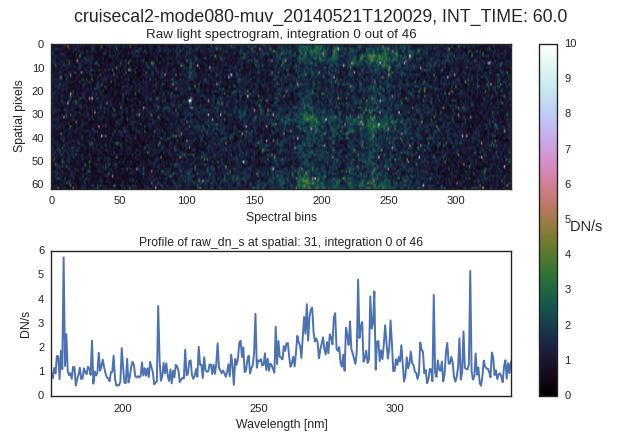

In [8]:
l1b.plot_raw_overview(0, save_token='1_int0', proflog=False, imglog=False);

In [8]:
l1b.plot_raw_overview??

<IPython.core.display.Javascript object>


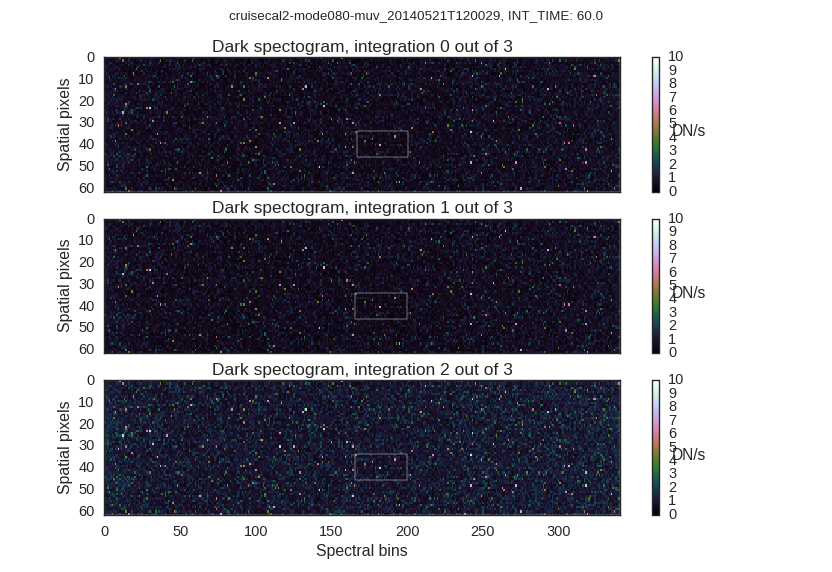

In [71]:
l1b.plot_dark_spectrograms()

<IPython.core.display.Javascript object>


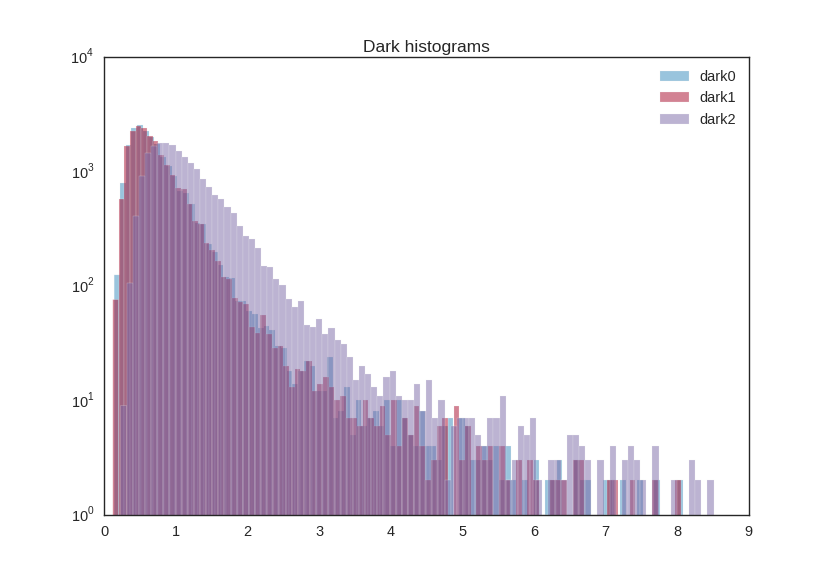

In [77]:
l1b.plot_dark_histograms()

In [13]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


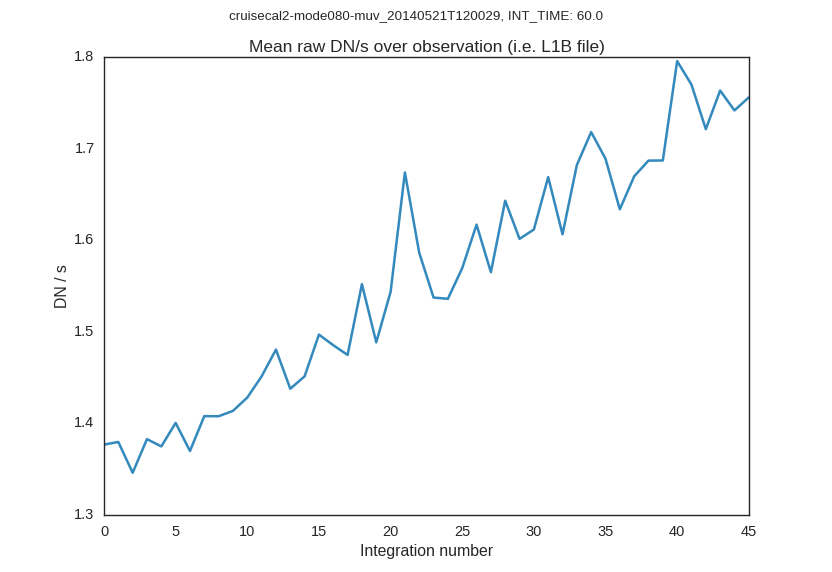

In [79]:
l1b.plot_mean_raw_values()

In [15]:
sets = [(0,0), (0,1), (1,0), (1,1), (1, -1), (-1, 1), (-1, -1)]

plt.ioff()
for index in sets:
    print(index)
    dfitter = scaling.DarkFitter(l1b, raw_integration=index[0], dark_integration=index[1])
    dfitter.plot_profiles(save_token='{}{}'.format(*index))
    plt.close('all')

(0, 0)
(0, 1)
(1, 0)
(1, 1)
(1, -1)
(-1, 1)
(-1, -1)


In [53]:
from IPython.html.widgets import IntProgress
from IPython.display import display
from time import sleep
ip = IntProgress(min=0, max=10)
display(ip)
for i in range(10):
    sleep(0.3)
    ip.value = i

In [52]:
i

0

In [94]:
plt.ioff()
from iuvs.multitools import *
for j in (range(l1b.n_darks)):
    print('doing dark {}'.format(j))
    results = []
    prog = IntProgress(min=0, max=l1b.n_integrations)
    display(prog)
    for i in range(l1b.n_integrations):
        fitter = scaling.DarkFitter(l1b, i, j)
        results.append(fitter.p_dicts)
        prog.value = i
    results = pd.DataFrame(results)
    results.index.name = 'Integrations'
#     results.plot(title="Dark{} against all lights".format(j))
    results.filter(regex='Scaler').plot(title="Dark{} against all lights".format(j))
    for col in results.filter(regex='poly1'):
        
    plt.savefig('/home/klay6683/plots/dark{}_vs_all_lights.png'.format(j), dpi=150)

doing dark 2


In [35]:
plt.ion()
%matplotlib nbagg

<IPython.core.display.Javascript object>


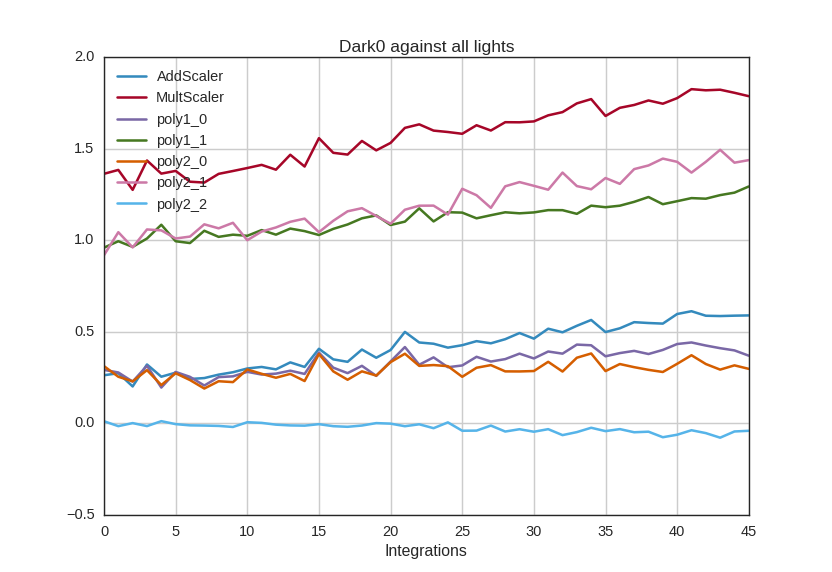

In [42]:
results.plot(title="Dark0 against all lights")

In [64]:
l1b.plottitle

'cruisecal2-mode080-muv_20140521T120029, INT_TIME: 60.0'

In [84]:
from iuvs.multitools import int_progress, float_progress